In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from numba import jit

import re
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk import pos_tag, word_tokenize

from spacy.lang.en.stop_words import STOP_WORDS

import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error,r2_score,accuracy_score
import spacy
from pandas.tseries.holiday import USFederalHolidayCalendar
from datetime import datetime
import string
import random
import datetime 
import calendar
import copy 
import timeit

pd.options.display.max_rows = 400000
pd.options.display.max_columns = 200

%matplotlib inline
%config IPCompleter.greedy=True


In [2]:
SAMPLE_SIZE  = 75000

Weekdays = ["Monday","Tuesday","Wednesday","Thursday","Friday"]
Weekends = ["Saturday","Sunday"]

In [45]:
df = pd.read_csv("Dataset.csv",encoding='utf-8-sig')
df.shape,df.isnull().values.any()

((356054, 9), True)

In [4]:
df_AllNull = (df[df.isnull().any(axis=1)]) 
df_KeywordNull = df[df['Keyword'].isnull()]
df_OtherNull = pd.concat([df_AllNull, df_KeywordNull,df_KeywordNull]).drop_duplicates(keep=False)
df_WithoutNull = pd.concat([df, df_AllNull,df_AllNull]).drop_duplicates(keep=False)
df_sample = df_WithoutNull.sample(n=SAMPLE_SIZE)

df.shape,df_WithoutNull.shape , df_AllNull.shape , df_KeywordNull.shape , df_OtherNull.shape,df_sample.shape

((356054, 9), (334342, 9), (3514, 9), (479, 9), (2883, 9), (75000, 9))

In [48]:
df.describe()

,Date,Average.Position,CPC,Clicks,Impressions,Cost
count,3.560540e+05,353018.000000,353018.000000,353018.000000,3.530180e+05,3.530180e+05
mean,2.012269e+07,0.611737,14.285071,439.052699,1.874365e+04,3.598259e+03
std,3.577676e+03,0.643839,37.858433,7559.532663,2.970826e+05,5.718301e+04
min,2.012052e+07,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,2.012090e+07,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
50%,2.012102e+07,1.000000,1.100000,2.120000,1.290000e+02,8.070000e+00
75%,2.012122e+07,1.000000,12.100000,35.230000,1.571000e+03,3.749975e+02
max,2.013021e+07,12.000000,632.730000,441963.500000,1.566667e+07,3.269108e+06


In [49]:
df.head()

,Date,Market,Keyword,Average.Position,CPC,Clicks,CTR,Impressions,Cost
0,20120524,US-Market,secure online back up,0.0,0.0,0.00,0.00%,0.0,0.00
1,20120524,US-Market,agile management software,1.0,1.2,21.22,8.20%,260.0,25.45
2,20120524,US-Market,crm for financial,0.0,0.0,0.00,0.00%,0.0,0.00
3,20120524,US-Market,disaster recovery planning for it,0.0,0.0,0.00,0.00%,0.0,0.00
4,20120524,US-Market,tracking a vehicle,0.0,0.0,0.00,0.00%,0.0,0.00


In [7]:
# takes around 30 secs

# nltk.download('stopwords')    
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

stop_words = stopwords.words('english')
nlp = spacy.load('en_core_web_md')
porter = PorterStemmer()
wnl = WordNetLemmatizer()
cal = USFederalHolidayCalendar()

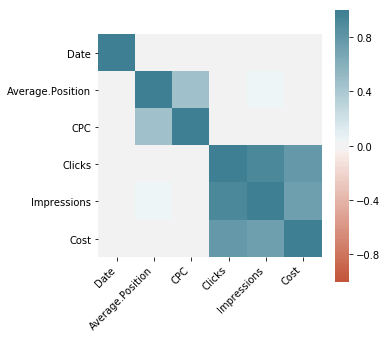

In [8]:
def PrintCorrelation(corr,fig_size_x=15,fig_size_y=15):
    plt.figure(figsize=(fig_size_x, fig_size_y))

    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );
#finding corelations
corr = df.corr()
PrintCorrelation(corr,5,5)

In [9]:
def RemoveStopWords(text):
    filtered_sentence =[]
    for word in text.split(" "):
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word) 
    return " ".join(filtered_sentence)



In [10]:
def FindAvgTfIdf(text):
    sum_tfidf=0
    for index,word in enumerate(text.split(" ")):
            tfidf_size = weights_df.loc[weights_df['term'] == word]["weight"].size
            if tfidf_size==0:         #if the word doesnt exist in tf idf list
                sum_tfidf+=0
            else:
                sum_tfidf += weights_df.loc[weights_df['term'] == word]["weight"].tolist()[0]
                    
    avg_tfidf = sum_tfidf/(index+1)
    return avg_tfidf

In [11]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [12]:
def LemmatizeSentence_inner(tokensPosTuple):
    lemSentence = ""
    for token in tokensPosTuple:
        word = token[0]
        posTag = get_wordnet_pos(token[1])
        
        if word!=None and word!="" and posTag!=None and posTag!="":
            wnl.lemmatize(word,posTag)
            lemSentence += wnl.lemmatize(token[0],get_wordnet_pos(token[1]))+" "
    return lemSentence

In [13]:
def LemmatizeSentence(sentence):
    tokens = word_tokenize(sentence)                 # tokenize the sentence
    tokensPosTuple = pos_tag(tokens)                #get pos tags
    return LemmatizeSentence_inner(tokensPosTuple)

In [14]:
def findDay(date): 
    born = datetime.datetime.strptime(date, '%d %m %Y').weekday() 
    return (calendar.day_name[born]) 

def isWeekday(date):
    day = findDay(date)
    if day in Weekdays:
        return True 
    else:
        return False

In [15]:
def GetWordVectorAndTfidfScore(sentence):
    loweredSentence = sentence.lower()               # get the keyword and lower it
    stoppedSentence = RemoveStopWords(loweredSentence)     # remove stop words
    lemSentence = LemmatizeSentence(stoppedSentence)         # get pos tags
    NLP_Sentence = nlp(lemSentence)                         # convert string to nlp -> spacy.tokens.doc.Doc
    vectorableSentence = " ".join([token.text for token in NLP_Sentence if token.has_vector])   #retain words which have vectors
    vectorableSentence = nlp(vectorableSentence)            # convert string to nlp -> spacy.tokens.doc.Doc
    
    avg_tfidf = FindAvgTfIdf(loweredSentence)               #get tf idf of the original lower cased sentence because
    
    return vectorableSentence.vector_norm*100 , avg_tfidf*10

In [16]:
# THIS WILL TAKE TIME : around 4-5 min


def TrainTfIdfModel():

    # using wiki people dataset to get generalized tf idf which will then be used for our corpus
    people_wiki_df = pd.read_csv("data\people_wiki.csv")
    CompleteSentence = []
    for index, row in people_wiki_df.iterrows():
        CompleteSentence.append(re.sub('[^A-Za-z0-9 ]+', '', people_wiki_df["text"][index]).lower())
    cvec = CountVectorizer(stop_words='english', min_df=4, max_df=0.5, ngram_range=(1,2))
    sf = cvec.fit_transform(CompleteSentence)

    transformer = TfidfTransformer()
    transformed_weights = transformer.fit_transform(sf)
    weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
    weights_df = pd.DataFrame({'term': cvec.get_feature_names(), 'weight': weights})
    weights_df['weight'] = weights_df['weight'].apply(lambda x: x*10)
    return weights_df

weights_df = TrainTfIdfModel()

###  Down Smapling 40k rows out of 3 lac rows

In [28]:
# #for word vector averaging
# def AddWordVectorsAndTfidf(df_sample):
#     print("IN AddWordVectorsAndTfidf ")
#     df_sample["AverageWordVector"] = np.nan
#     df_sample["tfidf_score"] = np.nan


#     counter = 0
#     for index, row in df_sample.iterrows():
#         counter +=1
#         if pd.isna(row["Keyword"]):
#             df_sample.at[index,'AverageWordVector'] = np.nan
#             df_sample.at[index,'tfidf_score'] = np.nan

#         else:
#             Keyword = row["Keyword"]
#             normVector, tfidf = GetWordVectorAndTfidfScore(Keyword)
#             df_sample.at[index,'AverageWordVector'] = normVector   
#             df_sample.at[index,'tfidf_score'] = tfidf   

#         if(counter%10==0):
#             print(counter,end=", ")   
#     return df_sample

In [25]:
def doPreProcessing(df_sample):
    print("\n IN PlayWithDateAndKeyword ")
    yearlist = []
    monthlist = []
    daylist = []


    df_sample['Year'] = 0
    df_sample['Month'] = 0
    df_sample['Day'] = 0
    df_sample['Date2'] = ""
    df_sample['KeywordLength'] = 0
    df_sample["Weekday"] = False
    df_sample["CTR2"] = 0.0
    df_sample["Market2"] = 0
    df_sample["AverageWordVector"] = np.nan
    df_sample["tfidf_score"] = np.nan    
    df_sample['Holiday'] = False
    
    counter = 0
    for index, row in df_sample.iterrows():
        counter +=1
        Keyword = row["Keyword"]
        if pd.isna(Keyword):
            df_sample.at[index,'AverageWordVector'] = np.nan
            df_sample.at[index,'tfidf_score'] = np.nan

        else:
            
            normVector, tfidf = GetWordVectorAndTfidfScore(Keyword)
            df_sample.at[index,'AverageWordVector'] = normVector   
            df_sample.at[index,'tfidf_score'] = tfidf   
        
        
        stringDate = str(row["Date"])
        Year = int(stringDate[0:4])
        Month = int(stringDate[4:6]) 
        Day = int(stringDate[6:8])
        df_sample.at[index,'Year'] = Year
        df_sample.at[index,'Month'] = Month
        df_sample.at[index,'Day'] = Day

        Date  = datetime.datetime.strptime(stringDate, '%Y%m%d')
        df_sample.at[index,'Date2'] = Date

        OriginalSentence = RemoveStopWords(Keyword)    # get keyword at row, lower cast it, lemmatize it
        df_sample.at[index,'KeywordLength'] = int(len(OriginalSentence.split(" ")))

        Date = str(Day) + " " + str(Month) + " " + str(Year)
        df_sample.at[index,'Weekday'] = isWeekday(Date)

        
        CTR = df_sample.at[index,'CTR']
        df_sample.at[index,'CTR2'] = float(CTR.split("%")[0])

        Market = df_sample.at[index,'Market']
        if Market == "US-Market":
            df_sample.at[index,'Market2'] = 1
        else:
            df_sample.at[index,'Market2'] = 0

        if(counter%100==0):
            print(counter,end=", ")
            
        if counter==SAMPLE_SIZE:
            break

    df_sample['Date2'] = pd.to_datetime(df_sample['Date2'], format='%Y%m%d')    
    holidays = cal.holidays(start=df_sample['Date2'].min(), end=df_sample['Date2'].max())
    df_sample['Holiday'] = df_sample['Date2'].isin(holidays)
    
    return df_sample

In [ ]:
# df_sample = AddWordVectorsAndTfidf(df_sample)
start = timeit.default_timer()

df_sample = doPreProcessing(df_sample)

stop = timeit.default_timer()
print('Time: ', stop - start) 

In [ ]:
#saving
#comment done so one doesnt run it accidently
#df_sample.to_csv("PreProcessing.csv")


In [ ]:
#loading
df_sample = pd.read_csv("PreProcessing.csv",index_col=0)
df_sample_copy = copy.deepcopy(df_sample)



In [ ]:
df_sample_copy.drop([ 'Year', 'Month', 'Day', 'Date2',
       'KeywordLength', 'Weekday', 'CTR2', 'Market2', 'AverageWordVector',
       'tfidf_score', 'Holiday'], axis = 1,inplace=True) 

df_sample_part2 = pd.concat([df_WithoutNull, df_sample_copy,df_sample_copy]).drop_duplicates(keep=False)
df_WithoutNull.shape,  df_sample_copy.shape,   df_sample2.shape

In [ ]:
# PRE PROCESSING OF PART 2 
start = timeit.default_timer()

df_sample_part2 = doPreProcessing(df_sample_part2)

stop = timeit.default_timer()
print('Time: ', stop - start) 

In [ ]:
#comment done so one doesnt run it accidently

#df_sample_part2.to_csv("PreProcessing_part2.csv")


In [4]:
df_sample_Combined = pd.read_csv("Combined.csv",index_col=0)
# df_sample_Combined_copy = copy.deepcopy(df_sample_Combined)
df_sample_Combined.shape

(151002, 20)

In [5]:
df_sample_Combined.head()

,Date,Market,Keyword,Average.Position,CPC,Clicks,CTR,Impressions,Cost,Year,Month,Day,Date2,KeywordLength,Weekday,CTR2,Market2,AverageWordVector,tfidf_score,Holiday
2,20120524,US-Market,crm for financial,0.0,0.0,0.0,0.00%,0,0.0,2012,5,24,5/24/2012 0:00,2,True,0.0,1,545.447478,0.056562,False
3,20120524,US-Market,disaster recovery planning for it,0.0,0.0,0.0,0.00%,0,0.0,2012,5,24,5/24/2012 0:00,3,True,0.0,1,508.290876,0.035015,False
4,20120524,US-Market,tracking a vehicle,0.0,0.0,0.0,0.00%,0,0.0,2012,5,24,5/24/2012 0:00,2,True,0.0,1,538.750366,0.011970,False
5,20120524,US-Market,applications in the cloud,0.0,0.0,0.0,0.00%,0,0.0,2012,5,24,5/24/2012 0:00,2,True,0.0,1,551.186216,0.017282,False
6,20120524,US-Market,project management with scrum,0.0,0.0,0.0,0.00%,0,0.0,2012,5,24,5/24/2012 0:00,3,True,0.0,1,461.238272,0.140611,False


# * PREPROCESSING END *

## * MODEL BUILDING *

### For predicting Clicks

In [21]:
X = df_sample_Combined.drop(['Date','Clicks','Keyword','Market','CTR','Date2','Year','Day'], axis=1)
y = df_sample_Combined['Clicks']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

X.shape,y.shape,X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((151002, 12), (151002,), (120801, 12), (30201, 12), (120801,), (30201,))

In [22]:
#Linear Regression
lin_reg_mod = LinearRegression()
lin_reg_mod.fit(X_train, y_train)
y_pred = lin_reg_mod.predict(X_test)

rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
adjR2 = 1-(1-r2)*((X_train.shape[0])-1)/((X_train.shape[0])-(X_train.shape[1])-1)

print("RMSE: %f" % rmse)
print("R2 score = ",r2)        # r2 score 
print("Adjusted R2 score = ",adjR2)

RMSE: 1460.213436
R2 score =  0.6679342949614837
Adjusted R2 score =  0.6679013050248968


In [ ]:
#SVM
clf = svm.SVR( gamma='scale', C=1.0, epsilon=0.2)
clf.fit(X_train,y_train) 
y_pred = clf.predict(X_test)


rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
adjR2 = 1-(1-r2)*((X_train.shape[0])-1)/((X_train.shape[0])-(X_train.shape[1])-1)

print("RMSE: %f" % rmse)
print("R2 score = ",r2)        # r2 score 
print("Adjusted R2 score = ",adjR2)

In [36]:
#XGBOOST

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.5,
                max_depth = 1000, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)
y_pred = xg_reg.predict(X_test)

rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
adjR2 = 1-(1-r2)*((X_train.shape[0])-1)/((X_train.shape[0])-(X_train.shape[1])-1)

print("RMSE: %f" % rmse)
print("R2 score = ",r2)        # r2 score 
print("Adjusted R2 score = ",adjR2)

C:\Users\umer.tariq\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE: 162.238753
R2 score =  0.9959007864524558
Adjusted R2 score =  0.995900379205357


### For predicting CLick through rate ratio

In [37]:
X = df_sample_Combined.drop(['Date','CTR2','Keyword','Market','CTR','Date2','Year','Day'], axis=1)
# putting CTR2 in y means we are gonna predict CTR
y = df_sample_Combined['CTR2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

X.shape,y.shape,X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((151002, 12), (151002,), (120801, 12), (30201, 12), (120801,), (30201,))

In [38]:
#Linear Regression
lin_reg_mod = LinearRegression()
lin_reg_mod.fit(X_train, y_train)
y_pred = lin_reg_mod.predict(X_test)

rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
adjR2 = 1-(1-r2)*((X_train.shape[0])-1)/((X_train.shape[0])-(X_train.shape[1])-1)

print("RMSE: %f" % rmse)
print("R2 score = ",r2)        # r2 score 
print("Adjusted R2 score = ",adjR2)

RMSE: 1.691520
R2 score =  0.38103071163636404
Adjusted R2 score =  0.3809692185123752


In [ ]:
#SVM
clf = svm.SVR( gamma='scale', C=1.0, epsilon=0.2)
clf.fit(X_train,y_train) 
y_pred = clf.predict(X_test)


rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
adjR2 = 1-(1-r2)*((X_train.shape[0])-1)/((X_train.shape[0])-(X_train.shape[1])-1)

print("RMSE: %f" % rmse)
print("R2 score = ",r2)        # r2 score 
print("Adjusted R2 score = ",adjR2)

In [39]:
#XGBOOST

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.5,
                max_depth = 1000, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)
y_pred = xg_reg.predict(X_test)

rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
adjR2 = 1-(1-r2)*((X_train.shape[0])-1)/((X_train.shape[0])-(X_train.shape[1])-1)

print("RMSE: %f" % rmse)
print("R2 score = ",r2)        # r2 score 
print("Adjusted R2 score = ",adjR2)

C:\Users\umer.tariq\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE: 0.149034
R2 score =  0.9951951072489301
Adjusted R2 score =  0.9951946298942839


# * MODEL BUILDING END *

## Evaluation on alredy given data

In [25]:
'''
this function returns the samples from df_without_null which are not in df_sample
params :
df_without_null = complete dataframe
df_sample = dataframe which you want to subtract from bigger dataframe
'''
# def GetNotInSample(df_WithoutNull,df_sample,limitOfNewSamples):
#     counter=0
#     keyword=""
#     CTR=""
#     counter2= 0
#     dfNotInSample = pd.DataFrame(columns=df_WithoutNull.columns.tolist())
#     for index, row in df_WithoutNull.iterrows():
#         counter +=1
#         Keyword = row["Keyword"]
#         CTR = row["CTR"]
#         found = df_sample[df_sample["Keyword"].str.contains(Keyword) & df_sample["CTR"].str.contains(CTR)]
#         if found.shape[0]==0:
#             dfNotInSample.loc[counter2] = row
#             counter2+=1
#             print("\n",counter2,end="\n")
#         if dfNotInSample.shape[0]==limitOfNewSamples:
#             break
#         if counter%100==0:
#             print(counter,end=", ")
#     return dfNotInSample

In [27]:
# # GetNotInSample takes rows which are not in df_sample and hence not trained
# dfNotInSample = GetNotInSample(df_WithoutNull,df_sample_Combined,10) # last 
# print("Got the dataframe, now moving on to processing")
# dfSingleEvaluate = doPreProcessing(dfNotInSample)


In [ ]:
# XSingleEvaluate = dfSingleEvaluate.drop(['Date','Clicks','Keyword','Market','CTR','Date2','Year','Day'], axis=1)
# ySingleEvaluate = dfSingleEvaluate['Clicks'].tolist()
# y_pred = xg_reg.predict(XSingleEvaluate).tolist()

# rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
# r2 = r2_score(y_test, y_pred)
# adjR2 = 1-(1-r2)*((X_train.shape[0])-1)/((X_train.shape[0])-(X_train.shape[1])-1)

# print("RMSE: %f" % rmse)
# print("R2 score = ",r2)        # r2 score 
# print("Adjusted R2 score = ",adjR2)

## Evaluation On Real World Test Data

In [33]:
def EvaluateAndPredictClicks(df_eval_path):
    df_eval = pd.read_csv(df_eval_path)
    print(df_eval.shape)
    dfSingleEvaluate = doPreProcessing(df_eval)

    XSingleEvaluate = dfSingleEvaluate.drop(['Date','Keyword','Market','CTR','Date2','Year','Day'], axis=1)
    clicks_pred = xg_reg.predict(XSingleEvaluate).tolist()

    df_eval["Predicted.Clicks"] = clicks_pred
    
    clicks_pred = [ '%.2f' % elem for elem in clicks_pred ]
    
    return df_eval

In [34]:
EvaluationFilePath = "Evaluate.csv"
df_eval = EvaluateAndPredictClicks(EvaluationFilePath)
df_eval

#df_eval.to_csv("Evaluated.csv")


(400, 8)

 IN PlayWithDateAndKeyword 
100, 200, 300, 400, 

,Date,Market,Keyword,Average.Position,CPC,CTR,Impressions,Cost,Year,Month,Day,Date2,KeywordLength,Weekday,CTR2,Market2,AverageWordVector,tfidf_score,Holiday,Predicted.Clicks
0,20130214,US-Market,cheap insurance life term,0.0,0.00,0.00%,0,0.00,2013,2,14,2013-02-14,4,True,0.0,1,476.124818,0.165399,False,0.000488
1,20130214,US-Market,home loans refinancing,1.0,7.63,3.80%,445,130.41,2013,2,14,2013-02-14,3,True,3.8,1,621.403727,0.115373,False,17.545540
2,20130214,US-Market,consolidate college loans,0.0,0.00,0.00%,0,0.00,2013,2,14,2013-02-14,3,True,0.0,1,577.581041,0.232436,False,0.000488
3,20130214,US-Market,cheap life insurance,1.0,58.88,3.30%,931,1806.63,2013,2,14,2013-02-14,3,True,3.3,1,516.754910,0.155190,False,30.955805
4,20130214,US-Market,vioxx law suit,0.0,0.00,0.00%,0,0.00,2013,2,14,2013-02-14,3,True,0.0,1,469.150222,0.204613,False,0.000488
5,20130214,US-Market,student loan refinance,1.0,11.66,2.20%,244,62.00,2013,2,14,2013-02-14,3,True,2.2,1,621.454036,0.089566,False,5.411176
6,20130214,US-Market,car hire alicante spain,0.0,0.00,0.00%,0,0.00,2013,2,14,2013-02-14,4,True,0.0,1,546.309878,0.067725,False,0.000488
7,20130214,US-Market,refinancing my home,1.0,3.24,3.50%,180,20.69,2013,2,14,2013-02-14,2,True,3.5,1,596.682763,0.111432,False,6.286180
8,20130214,US-Market,criminal dallas lawyer,0.0,0.00,0.00%,0,0.00,2013,2,14,2013-02-14,3,True,0.0,1,546.064995,0.102390,False,0.000488
9,20130214,US-Market,line of credit home equity,0.0,0.00,0.00%,0,0.00,2013,2,14,2013-02-14,4,True,0.0,1,463.082919,0.111427,False,0.000488
